In [1]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullLocator, FixedLocator
import pandas as pd
import numpy as np
import seaborn as sb
import cartopy.crs as ccrs
from datetime import datetime as dt, timedelta
from math import factorial

from pathlib import Path

In [3]:
from lropy.analysis.io import load_pickled_simulation_results
from lropy.analysis.io import pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.constants import JULIAN_DAY, moon_polar_radius, earth_equatorial_radius, c
from lropy.analysis.maps import moon_globe

In [4]:
def get_orbit_start(n_orbit):
    # 83 min to start opposite of subsolar point
    return pd.to_datetime(dt(2010, 9, 26, 6) + timedelta(minutes=n_orbit*113) + timedelta(minutes=83), utc=True)

In [5]:
def get_orbit_number(time):
    time -= get_orbit_start(0)
    return (time.days * JULIAN_DAY + time.seconds) / (113 * 60)

In [6]:
orbit_steps = int(113 * 60 / 10)

# Orbit geometry

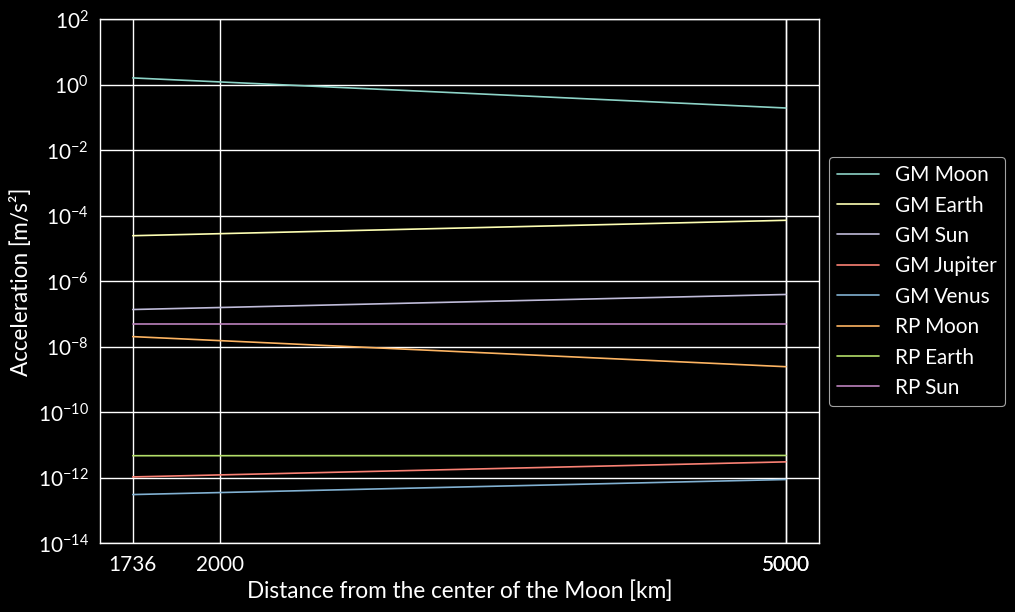

In [14]:
def plot_all_accelerations_magnitude():
    def grav_central(body, r, r_moon=None):
        gm = {
            "earth": 0.39860e6,
            "sun": 132712e6,
            "moon": 0.00490e6,
            "jupiter": 126.687e6,
            "venus": 0.32486e6
        }[body]  # km^3/s^2
    
        if body == "moon":
            # Regular central gravity
            return  gm / r**2 * 1e3
        else:
            # Perturbation
            return 2 * gm * r_moon / r**3 * 1e3
    
    # def grav_higher_order(n, m, r):
    #     def normalization_coeff(n, m):
    #         delta = 1 if m == 0 else 0
    #         return np.sqrt(factorial(n + m) / ((2 - delta) * (2*n + 1) * factorial(n - m)))
        
    #     J = {
    #         (2, 0): 9.088,
    #         (2, 2): 3.467e-5 + 9.079e-10,
    #     }[(n, m)] / normalization_coeff(n, m)
    #     return 0.00490e9 * 1738 ** n / r ** (n+2) * J

    def rp(body, r):
        A_m_Cp = 11.52 / 1087 * 1.04  # m^2/kg
        sun_luminosity = 3.828e26 / 1e6  # W

        if body == "sun":
            solar_irradiance = sun_luminosity / (4 * np.pi * r**2)
            return A_m_Cp * solar_irradiance / c
        elif body == "moon":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_moon_sun**2)
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            albedo = 0.19 / 2 * (moon_polar_radius/1e3 / r)**2 * acc_rp_sun
            moon_thermal_irr = 900  # somewhat arbitrary average from Lemoine 2013, but order of magnitude not very sensitive to exact value
            thermal = 0.95 / 2 * A_m_Cp * moon_thermal_irr / c * (moon_polar_radius/1e3 / r)**2
            return albedo + thermal
        elif body == "earth":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_earth_sun**2)
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            return (0.34 / 2 + 0.68 / 4) * (earth_equatorial_radius/1e3 / r)**2 * acc_rp_sun
    
    r_moon_earth = 384400
    r_moon_sun = 149601851
    r_moon_jupiter = 744857858
    r_moon_venus = 154196622
    r_earth_sun = r_moon_sun

    rr_moon = np.linspace(moon_polar_radius / 1e3, 5e3, 20)  # km
    rr_earth = r_moon_earth - rr_moon
    rr_sun = r_moon_sun -rr_moon
    rr_jupiter = r_moon_jupiter - rr_moon
    rr_venus = r_moon_venus - rr_moon

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(rr_moon, grav_central("moon", rr_moon), label="GM Moon")
    ax.plot(rr_moon, grav_central("earth", rr_earth, rr_moon), label="GM Earth")
    ax.plot(rr_moon, grav_central("sun", rr_sun, rr_moon), label="GM Sun")
    ax.plot(rr_moon, grav_central("jupiter", rr_jupiter, rr_moon), label="GM Jupiter")
    ax.plot(rr_moon, grav_central("venus", rr_venus, rr_moon), label="GM Venus")

    ax.plot(rr_moon, rp("moon", rr_moon), label="RP Moon")
    ax.plot(rr_moon, rp("earth", rr_earth), label="RP Earth")
    ax.plot(rr_moon, rp("sun", rr_sun), label="RP Sun")

    ax.set_xlabel("Distance from the center of the Moon [km]")
    ax.set_ylabel("Acceleration [m/s²]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim([1e-14, 1e2])
    # ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    format_plot(x_major_locator=FixedLocator([rr_moon[0], 2e3, 5e3, rr_moon[-1]]), x_minor_locator=NullLocator())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plot_all_accelerations_magnitude()

Want to only consider accelerations much larger than RP which significantly determine orbit over 2.5 day arc.

# Lunar models

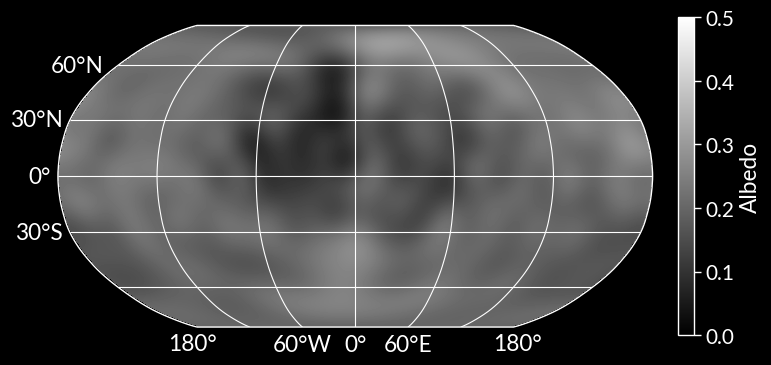

In [8]:
def plot_albedo_map():
    albedo_map = np.load("../private/dlam1.npy")

    fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True, subplot_kw=dict(projection=ccrs.Robinson(globe=moon_globe)))

    im = ax.imshow(albedo_map, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.5)
    fig.colorbar(im, ax=ax, label="Albedo", fraction=0.025, pad=0.04)
    ax.gridlines(draw_labels=["bottom", "left"], crs=ccrs.PlateCarree(globe=moon_globe))
    
plot_albedo_map()